In [25]:
import os
import pandas as pd

from data_cleaning.utils.fill_missing_utils import (
    get_percentage_missing,
    get_entries_with_missing_values,
    plot_missing
)

In [26]:
file_path = '../data/2_destination_norm.parquet'
output_file_path = '../data/cleaned_data_no_labels.parquet'

if not os.path.exists(file_path):
    print(f"File not found: {file_path}")

df = pd.read_parquet(file_path)
# df.dtypes

In [27]:
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

df = df.drop_duplicates()
df = df.reset_index(drop=True)
len(df)

Number of duplicate rows: 0


913599

df = df.drop_duplicates()
**1. Converting impossible values to NaN:**

- TH: should only have values 0-360, but has 500
**Heading (degrees) of the vessel's hull. A value of 511 indicates there is no heading data.**
[link](https://api.vtexplorer.com/docs/response-ais.html#:~:text=Heading%20(degrees)%20of%20the%20vessel's,there%20is%20no%20heading%20data.&text=Dimension%20(meters)%20from%20AIS%20GPS%20antenna%20to%20the%20Stern%20of,Vessel%20Length%20=%20A%20+%20B)
- COG: should only have values 0-360
--------------------------------
- Latitude one really low value
- SOG: 3 examples with superspeed ships
-------STATIC---------
- Length and Breadth should be positive
- Draught 0 and really high values


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

 Yes, a draft of 0.1 is certainly possible. The term "draft" refers to the vertical distance between the waterline and the lowest part of a ship's hull. This means that even a very small draft of 0.1 is possible, as it simply means the ship is sitting low in the water, possibly due to being lightly loaded or having a design that allows for minimal depth.



In [28]:
import numpy as np

df['Length'] = df['Length'].apply(lambda x: x if x > 0 else  np.nan)
df['Breadth'] = df['Breadth'].apply(lambda x: x if x > 0 else  np.nan)
df['Draught'] = df['Draught'].apply(lambda x: x if 0 < x else  np.nan)
df['shiptype'] = df['shiptype'].apply(lambda x: x if 0 < x else  np.nan)
df['Destination'] = df['Destination'].fillna(pd.NA)

df['TH'] = df['TH'].apply(lambda x: x if 0 <= x <= 360 or x == 511 else None)
df['COG'] = df['COG'].apply(lambda x: x if 0 <= x <= 360 else None)

# df['SOG'] = df['SOG'].apply(lambda x: x if x <= 60 else None)    #NOTE CAN BE CHANGED
df = df[df['SOG'] < 30] # Drop rows where SOG is greater than or equal to 30

In [29]:
# plot_missing(df)

In [30]:
get_percentage_missing(df)

TripID            0.00000
StartLatitude     0.00000
StartLongitude    0.00000
StartTime         0.00000
EndLatitude       0.00000
EndLongitude      0.00000
EndTime           0.00000
StartPort         0.00000
EndPort           0.00000
time              0.00000
shiptype          0.71782
Length            1.12260
Breadth           1.12260
Draught           1.78449
Latitude          0.00000
Longitude         0.00000
SOG               0.00000
COG               0.00011
TH                0.00000
Destination       0.57586
dtype: float64

| Parameter     | Missing % |
|---------------|-----------|
| shiptype      | 0.71782   |
| Length        | 1.12260   |
| Breadth       | 1.12260   |
| Draught       | 1.78449   |
| COG           | 0.00011   |
| Destination   | 0.57586   |

After 3

| Parameter   | Missing %   |
|-------------|-------------|
| shiptype    | **0.15291** |
| Length      | **0.47143** |
| Breadth     | **0.47143** |
| Draught     | **1.77901** |
| COG         | **0.00000** |
| Destination | **0.00744** |

After 4

| Parameter     | Missing % |
|---------------|-----------|
| Destination   | 0.007443  |
| shiptype      | 0.152912  |


## 2. Destination

See if we can just fill in missing values with the nearest value within the same TripID

In [31]:
get_entries_with_missing_values(df, 'Destination')

TripID
5944       [PL.GDY, <NA>]
19002              [<NA>]
19585      [PL.GDY, <NA>]
23834      [PL.GDN, <NA>]
28257      [PL.GDN, <NA>]
                ...      
2183505    [PL.GDN, <NA>]
2200956            [<NA>]
2258835    [PL.GDY, <NA>]
2263639    [PL.GDN, <NA>]
2271342    [PL.GDN, <NA>]
Name: Destination, Length: 249, dtype: object

In [32]:
# df.loc[df['TripID'] == 29152]
df.loc[9311]

TripID                                29152
StartLatitude                         54.36
StartLongitude                        10.14
StartTime         2016-04-05 11:51:00+00:00
EndLatitude                           54.38
EndLongitude                          18.65
EndTime           2016-04-07 15:36:00+00:00
StartPort                              KIEL
EndPort                              GDYNIA
time              2016-04-06 05:39:00+00:00
shiptype                                NaN
Length                                  NaN
Breadth                                 NaN
Draught                                7.33
Latitude                              55.76
Longitude                             17.72
SOG                                    17.4
COG                                    91.3
TH                                       91
Destination                            <NA>
Name: 9311, dtype: object

df.loc[df['TripID'] == 355595]  # Check the first trip with missing Destination
Not really but we can fill missing values with the nearest value within the same TripID and more matching coordinates.
Find the first nan value above and below it will fill it with the nearest value within the same TripID and more matching coordinates.

In [33]:
from data_cleaning.utils.fill_missing_utils import fill_missing_destinations_by_proximity

df_dest = fill_missing_destinations_by_proximity(df)
print(get_percentage_missing(df_dest, 'Destination'))

Processing 1126 trips for destination proximity filling...
Filled 5193 missing destination values using proximity method
0.00744


**No Destination at All**

In [34]:
get_entries_with_missing_values(df_dest, 'Destination')

TripID
19002      [<NA>]
2200956    [<NA>]
Name: Destination, dtype: object

### Functions

In [35]:
has_none = df.groupby("TripID")['Length'].apply(lambda x: x.isna().any())
has_none

TripID
5944        True
10257      False
19002       True
19585       True
23834       True
           ...  
2278113    False
2278114    False
2278125    False
2278140    False
2278147    False
Name: Length, Length: 1126, dtype: bool

In [36]:
def get_inconsistent_trip_ids(df, column):
    nunique_values = df.groupby("TripID")[column].nunique()

    has_nan_values = df.groupby("TripID")[column].apply(lambda x: x.isna().any())
    inconsistent_by_nunique = nunique_values > 1
    inconsistent_by_nan_and_value = has_nan_values & (nunique_values > 0)
    inconsistent_trip_ids = (inconsistent_by_nunique | inconsistent_by_nan_and_value)

    return inconsistent_trip_ids.loc[lambda x: x].index

def make_inconsistent_mode(dataf, column):
    inconsistent_trip_ids = get_inconsistent_trip_ids(dataf, column)

    for trip_id in inconsistent_trip_ids:
        trip_mask = dataf["TripID"] == trip_id

        mode_values = dataf.loc[trip_mask, column].mode(dropna=True)
        print(f"Calculated mode values (Series):\n{mode_values.to_list()}")

        if not mode_values.empty:
            chosen_mode = mode_values[0]
            print(f"First mode chosen: {chosen_mode}")
            # Replace ALL values (including nulls) with the first mode
            dataf.loc[trip_mask, column] = chosen_mode
        else:
            print(f"No mode found for TripID: {trip_id} after dropping NaNs.")

    return dataf # assuming you want to return the modified DataFrame

def all_fill_with_mode(dataf, column):
    print("-"* 40)
    print(" "*20,f"Before filling {column}")
    print(f"percentage of missing:" , get_percentage_missing(df_lbs, column))
    print("Inconsistent Trip IDs:\n", get_inconsistent_trip_ids(dataf, column))
    make_inconsistent_mode(dataf, column)
    print(" "*20, f"After filling {column}")
    print(f"percentage of missing:" , get_percentage_missing(dataf, column))
    print("Inconsistent Trip IDs:\n", get_inconsistent_trip_ids(dataf, column))
    print("-"* 40)




### 3 Length && Breadth && Shiptype

In [37]:
df_lbs = df_dest.copy()

In [38]:
all_fill_with_mode(df_lbs, 'Length')

----------------------------------------
                     Before filling Length
percentage of missing: 1.1226
Inconsistent Trip IDs:
 Index([   5944,   19585,   23834,   28257,   29139,   29152,   29165,   29190,
         32680,   32692,
       ...
       1998836, 2022611, 2183472, 2183480, 2183488, 2183505, 2201111, 2258835,
       2263639, 2271342],
      dtype='int64', name='TripID', length=249)
Calculated mode values (Series):
[82.0]
First mode chosen: 82.0
Calculated mode values (Series):
[81.0]
First mode chosen: 81.0
Calculated mode values (Series):
[87.0]
First mode chosen: 87.0
Calculated mode values (Series):
[175.0]
First mode chosen: 175.0
Calculated mode values (Series):
[151.0]
First mode chosen: 151.0
Calculated mode values (Series):
[151.0]
First mode chosen: 151.0
Calculated mode values (Series):
[151.0]
First mode chosen: 151.0
Calculated mode values (Series):
[151.0]
First mode chosen: 151.0
Calculated mode values (Series):
[151.0]
First mode chosen: 151.0
Calcul

In [39]:
all_fill_with_mode(df_lbs, 'Breadth')

----------------------------------------
                     Before filling Breadth
percentage of missing: 1.1226
Inconsistent Trip IDs:
 Index([   5944,   19585,   23834,   28257,   29139,   29152,   29165,   29190,
         32680,   32692,
       ...
       1998825, 1998836, 2022611, 2183472, 2183480, 2183488, 2183505, 2258835,
       2263639, 2271342],
      dtype='int64', name='TripID', length=247)
Calculated mode values (Series):
[12.0]
First mode chosen: 12.0
Calculated mode values (Series):
[12.0]
First mode chosen: 12.0
Calculated mode values (Series):
[14.0]
First mode chosen: 14.0
Calculated mode values (Series):
[26.0]
First mode chosen: 26.0
Calculated mode values (Series):
[24.0]
First mode chosen: 24.0
Calculated mode values (Series):
[24.0]
First mode chosen: 24.0
Calculated mode values (Series):
[24.0]
First mode chosen: 24.0
Calculated mode values (Series):
[24.0]
First mode chosen: 24.0
Calculated mode values (Series):
[23.0]
First mode chosen: 23.0
Calculated mode v

#### Shiptype

In [40]:
df_lbs['shiptype'] = df_lbs['shiptype'].apply(lambda x: x if 0 < x else None)

In [66]:
print(get_percentage_missing(df_lbs, 'shiptype'))

valid_trips = df_lbs.groupby('TripID')['shiptype'].transform(lambda x: x.notna().any())
# Forward-fill ONLY in trips that have at least one non-null shiptype
df_lbs['shiptype'] = (
    df_lbs.groupby('TripID')['shiptype']
    .ffill()
    .where(valid_trips)  # Keep filled values only in valid trips
    .combine_first(df_lbs['shiptype'])  # Restore original NaN where no fill occurred
)

print(get_percentage_missing(df_lbs, 'shiptype'))

0.15291
0.15291


In [67]:
get_entries_with_missing_values(df_lbs, 'shiptype')

TripID
19002      [nan]
1290901    [nan]
1866491    [nan]
1888742    [nan]
2200956    [nan]
Name: shiptype, dtype: object

<Axes: >

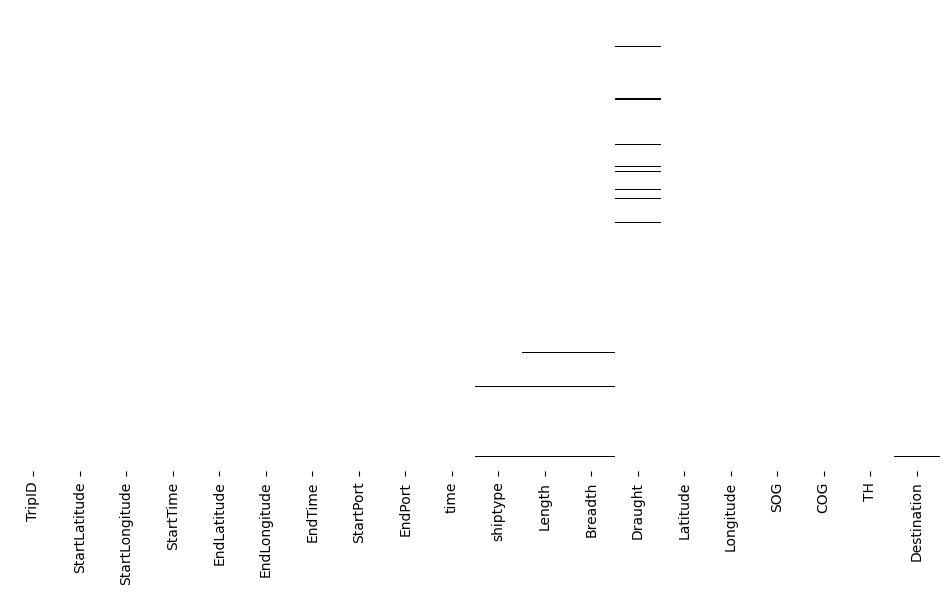

In [43]:
plot_missing(df_lbs)

As if see then ship type is missing together with Length and Breadth.
The mean doesn't make sense here
Idk what to do with it, now

Clustering is an option but I will bother with it later

#### Draught

In [44]:
df_drght = df_lbs.copy()

#### Not all nulls

In [45]:
# has none but at least one proper
mixed_draught_trips = (
    df_drght.groupby("TripID")["Draught"]
    .apply(lambda x: x.notna().any() and x.isna().any())
    .loc[lambda x: x]  # Filter only True cases
    .index
    .tolist()
)
mixed_draught_trips
#After looking in the data for this we can use median of the trip to fill in the missing values or interpolate

[1993380, 2035831]

In [46]:
print(get_percentage_missing(df_drght, 'Draught'))

trip_medians = df_drght[df_drght["TripID"].isin(mixed_draught_trips)].groupby("TripID")["Draught"].median()

df_drght_cp = df_drght.copy()
for trip_id in mixed_draught_trips:
    mask = (df_drght_cp["TripID"] == trip_id) & (df_drght_cp["Draught"].isna())
    df_drght_cp.loc[mask, "Draught"] = trip_medians[trip_id]

# df['Draught'] = df.groupby('TripID')['Draught'].interpolate()
print(get_percentage_missing(df_drght_cp, 'Draught'))

1.78449
1.77901


#### All nulls

In [47]:
# No values at all

trips_with_no_draught = df_drght_cp.groupby('TripID')['Draught'].apply(
    lambda x: x.isna().all()
)
no_draught_trip_ids = trips_with_no_draught[trips_with_no_draught].index.tolist()
no_draught_trip_ids

[134726,
 199665,
 370742,
 370750,
 370761,
 370767,
 370773,
 370779,
 370785,
 370805,
 370816,
 370827,
 447271,
 646698,
 719608,
 719625,
 754511,
 754519,
 820282,
 827699,
 886651,
 1059962]

#### Cog

In [48]:
df_cog = df_drght_cp.copy()

In [49]:
# df_cog['COG'].isnull()
# df_cog.loc[df_cog['TripID'] == 1778056]
#The null is last entry id data series
df_cog['COG'] = df_cog['COG'].fillna(0)

In [50]:
get_percentage_missing(df_cog)

TripID            0.00000
StartLatitude     0.00000
StartLongitude    0.00000
StartTime         0.00000
EndLatitude       0.00000
EndLongitude      0.00000
EndTime           0.00000
StartPort         0.00000
EndPort           0.00000
time              0.00000
shiptype          0.15291
Length            0.47143
Breadth           0.47143
Draught           1.77901
Latitude          0.00000
Longitude         0.00000
SOG               0.00000
COG               0.00000
TH                0.00000
Destination       0.00744
dtype: float64

## 4. All nulls for time entry

Draught higly colerated to Length and Breadth, so we can use them to fill in the missing values

In [51]:
df_regression = df_cog.copy()

In [52]:
print(df_regression['Draught'].corr(df_regression['Length']))
print(df_regression['Draught'].corr(df_regression['Breadth']))
print(df_regression['Length'].corr(df_regression['Breadth']))

0.865310104430648
0.8559429515375492
0.9397848338458825


Train a HistGradientBoostingRegressor model to predict missing Draught values based on Length and Breadth:

In [53]:
df_regression['Draught'].isnull().count()

913596

In [54]:
from sklearn.metrics import r2_score
from sklearn.ensemble import HistGradientBoostingRegressor

# Function to fill missing values safely
def fill_missing(df, target_col, feature_cols, round_values=True):
    df_copy = df.copy()  # Work on a copy to avoid modifying the original DataFrame
    known = df_copy.dropna(subset=[target_col])
    missing = df_copy[df[target_col].isna()]

    if len(missing) == 0:
        return df  # No missing values to fill

    X_train = known[feature_cols]
    y_train = known[target_col]
    X_test = missing[feature_cols]

    model = HistGradientBoostingRegressor()
    model.fit(X_train, y_train)
    predicted_values = model.predict(X_test)
    predicted_values_int = np.round(predicted_values).astype(int)
    prediction = predicted_values_int if round_values else predicted_values
    df_copy.loc[df_copy[target_col].isna(), target_col] = prediction
    print("R2 score", r2_score(y_train, model.predict(X_train)))

    return df_copy

print("Missing Draught (%):", get_percentage_missing(df_regression, 'Draught'))
print("Missing Length (%):", get_percentage_missing(df_regression, 'Length'))
print("Missing Breadth (%):", get_percentage_missing(df_regression, 'Breadth'))


# Fill Length first (using Breadth + Draught)
df_regression = fill_missing(df_regression, 'Length', ['Breadth', 'Draught'])

# Then fill Breadth (using Length + Draught)
df_regression = fill_missing(df_regression, 'Breadth', ['Length', 'Draught'])

# Fill Draught first (using Length + Breadth)
df_regression = fill_missing(df_regression, 'Draught', ['Length', 'Breadth'], round_values=False)


# Verify no missing values remain
print("Missing Draught (%):", df_regression['Draught'].isnull().sum() / len(df_regression) * 100)
print("Missing Length (%):", df_regression['Length'].isnull().sum() / len(df_regression) * 100)
print("Missing Breadth (%):", df_regression['Breadth'].isnull().sum() / len(df_regression) * 100)

Missing Draught (%): 1.77901
Missing Length (%): 0.47143
Missing Breadth (%): 0.47143
R2 score 0.9909090749243431
R2 score 0.997434121572864
R2 score 0.9606532752555232
Missing Draught (%): 0.0
Missing Length (%): 0.0
Missing Breadth (%): 0.0


In [55]:
print(get_percentage_missing(df_regression))


TripID            0.00000
StartLatitude     0.00000
StartLongitude    0.00000
StartTime         0.00000
EndLatitude       0.00000
EndLongitude      0.00000
EndTime           0.00000
StartPort         0.00000
EndPort           0.00000
time              0.00000
shiptype          0.15291
Length            0.00000
Breadth           0.00000
Draught           0.00000
Latitude          0.00000
Longitude         0.00000
SOG               0.00000
COG               0.00000
TH                0.00000
Destination       0.00744
dtype: float64


In [56]:
# plot_missing(df_regression)

### Save

In [57]:
df_final = df_regression.copy()

# Rename columns to match the desired format

In [58]:
column_mapping = {
    'TripID':           'trip_id',
    'StartLatitude':    'start_latitude',
    'StartLongitude':   'start_longitude',
    'StartTime':        'start_time',
    'EndLatitude':      'end_latitude',
    'EndLongitude':     'end_longitude',
    'EndTime':          'end_time',
    'StartPort':        'start_port',
    'EndPort':          'end_port',
    'time':             'time_stamp',
    'shiptype':         'ship_type',
    'Length':           'length',
    'Breadth':          'breadth',
    'Draught':          'draught',
    'Latitude':         'latitude',
    'Longitude':        'longitude',
    'SOG':              'speed_over_ground',
    'COG':              'course_over_ground',
    'TH':               'true_heading',
    'Destination':      'destination',
}

# Apply renaming
df_final = df_final.rename(columns=column_mapping)

In [59]:
df_final.info

<bound method DataFrame.info of         trip_id  start_latitude  start_longitude                start_time  \
0          5944           54.36            10.14 2016-08-08 04:10:00+00:00   
1          5944           54.36            10.14 2016-08-08 04:10:00+00:00   
2          5944           54.36            10.14 2016-08-08 04:10:00+00:00   
3          5944           54.36            10.14 2016-08-08 04:10:00+00:00   
4          5944           54.36            10.14 2016-08-08 04:10:00+00:00   
...         ...             ...              ...                       ...   
913594  2278147           53.58             8.52 2016-10-19 22:10:00+00:00   
913595  2278147           53.58             8.52 2016-10-19 22:10:00+00:00   
913596  2278147           53.58             8.52 2016-10-19 22:10:00+00:00   
913597  2278147           53.58             8.52 2016-10-19 22:10:00+00:00   
913598  2278147           53.58             8.52 2016-10-19 22:10:00+00:00   

        end_latitude  end_longi

In [60]:
duplicate_count = df_final.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

df_final = df_final.drop_duplicates()
df_final = df_final.reset_index(drop=True)
len(df_final)

Number of duplicate rows: 1


913595

In [68]:
df_final['is_anomaly'] = None
df_final = df_final.sort_values(by=['trip_id', 'time_stamp']).reset_index(drop=True)

In [69]:
df_final.to_parquet(output_file_path)

### Divide data set for two tips

In [63]:
print(df_final['start_port'].unique())
print(df_final['end_port'].unique())

<StringArray>
['KIEL', 'BREMERHAVEN']
Length: 2, dtype: string
<StringArray>
['GDYNIA', 'HAMBURG']
Length: 2, dtype: string


In [64]:
df_from_KIEL = df_final[df_final['start_port'] == 'KIEL'].copy().reset_index(drop=True)
df_from_BREMERHAVEN = df_final[df_final['start_port'] == 'BREMERHAVEN'].copy().reset_index(drop=True)

In [65]:
df_from_KIEL.to_parquet('../data/from_KIEL.parquet')
df_from_BREMERHAVEN.to_parquet('../data/from_BREMERHAVEN.parquet')